In [1]:
from PreFRBLE.convenience import *
from PreFRBLE.estimate_redshift import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *
from PreFRBLE.sample import *

In [2]:
scenario = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18/smd'],
    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
}

scenario = {
    'IGM' : ['primordial'],
    'Host': ['JF12/StarDensity_MW'],
    'Local': ['Piro18/wind'], 
}


scenario_IGM = {
    'IGM' : ['primordial'],
}

Cs = np.arange(0.500,0.901, 0.100)  ### !!!! change to 0.3 - 0.9
f_IGMs = Cs
f_IGMs_range = f_IGMs-0.05
f_IGMs_range = np.append( f_IGMs_range, f_IGMs[-1]+0.05)



joint investigation of IGM baryon content and redshift population of FRBs.
Using prediction of $P(z|{\rm telescope},{\rm population})$ and $P({\rm DM}|z,C)$, we arrive at prediction of observed DM by integration, $P({\rm DM}|C,{\rm telescope},{\rm population}) = \int P(z|{\rm telescope},{\rm population}) ~ P({\rm DM}|z,C) ~{\rm d}z$ and quantify how well that fits to $P(DM|{\rm observed})$.

In [3]:


def LikelihoodObservedDM( scenario={}, telescope='Parkes', population='SMD', FRBs=None, DMs=None, use_localized=True, plot=False, plot_FRBs=False, ax=None, label=None, title=None ):
    """ 
    returns likelihood of values of DM observed by telescope for the case of scenario and population
    
    Parameters
    ----------
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
    
    Returns
    -------
    likelihoods : array-like
        1D array with likelihoods of individual DM observed by telescope  
    """

    P_DM, DM = GetLikelihood_Telescope( measure='DM', telescope=telescope, population=population, **scenario )
        
    if DMs is None:
        ## read observed values of extragalactic DM
        if FRBs is None:
            FRBs = GetFRBcat( telescopes=[telescope] )
        DMs = FRBs['DM']-FRBs['DM_gal']
    
    if plot:
        if ax is None:
            fig, ax = plt.subplots()
        if title is None:
            title = "%s with %s" % (population, telescope)
        ax.set_title( title )
        PlotLikelihood( P=P_DM, x=DM, measure='DM', ax=ax, label=label )
        
#        est, dev = Likelihood2Expectation( P=P_DM, x=DM, log=True, density=True )
#        print( telescope, population, "%f + %f - %f" %( est, dev[1], dev[0] ) )

        if plot_FRBs:
#            y_DMs = 0.75-0.5*np.random.rand(len(DMs))
#            ax.plot( DMs, y_DMs, marker='x', linestyle=' ' )
            P_, x_ = Histogram( data=DMs, bins=10, log=True, density=True, range=(1e1,1e4) )
            PlotLikelihood( P=P_, x=x_, measure='DM', ax=ax, label="observed", linestyle='-.', color='black' )
#        AllSidesTicks( ax )
    
    ## compute likelihood of observation
    likelihoods = Likelihoods( measurements=DMs, P=P_DM, x=DM )
    
    ## for FRBs with localized host, use likelihood for DM from that redshift, P(DM|z_host), instead
    if use_localized:
        localized, = np.where( FRBs['host_redshift']>0 )
        ## selection effects of telescope don't change ratio of prior likelihood of z between populations, but too low number of FRBs to reconstruct population can result in numerical errors. Thus use the cosmic population instead, which has better statistics.
        ##P_z, z = GetLikelihood_Redshift( population=population, telescope='None' )
        ## THIS IS BULLSHIT, since the maximum observable value of redshift cuts the prior, these values are renormalized differently. This has to be taken into account, e. g. by cutting the cosmic population at maximum redshift
        ##P_z, z = LikelihoodMeasureable( P=P_z, x=z, min=0, max=0.75 )
        ## HOWEVER, this strongly depends on the choice of maximum redshift ...
        
        for loc in localized:
            z_host = np.round(FRBs[loc]['host_redshift'],1)
            
            P_z, z = GetLikelihood_Redshift( population=population, telescope=telescope )
            P_DM, DM = GetLikelihood_Full( measure='DM', redshift=z_host, **scenario )
            ## likelihood for host redshift in population 
            prior = Likelihoods( measurements=[z_host], P=P_z, x=z ) ##**( 1 - (telescope in ['ASKAP']) )  ## ignore redhift prior for these telescope, since they are not informative for population
            ## multiply by likelihood for DM at host redshift
            likelihoods[loc], = Likelihoods( measurements=[DMs[loc]], P=P_DM, x=DM ) * prior 
#            print(  Likelihoods( measurements=[DMs[loc]], P=P_DM, x=DM ), Likelihoods( measurements=[z_host], P=P_z, x=z ))
#        print( telescope, population, scenario['IGM'], likelihoods[localized] )
        if plot and False:
            y_DMs = 0.75-0.5*np.random.rand( len(localized) )
            ax.plot( DMs[localized], y_DMs, marker='x', linestyle=' ' )
    return likelihoods

def LikelihoodBaryonContent( Cs=Cs, scenario={}, telescope='Parkes', population='SMD', FRBs=None, DMs=None ):
    """ 
    returns likelihood of values of C in DM_EG = C*z*1000 pc cm^-3, that present different IGM baryon contents.
    Likelihoods are quantified by how well DM observed by telescope agree with predictions for the case of scenario and population
    
    Parameters
    ----------
    Cs : array-like
        possible values of C
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
        
    Returns
    -------
    likelihoods : array-like
        2D array with likelihoods of values of C according to individual DM observed by telescope
    """
    
    if FRBs is None:
        FRBs = GetFRBcat( telescopes=[telescope] )
    
    likelihoods = []
    for C in Cs:
        tmp = scenario.copy()
        tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]
        likelihoods.append( LikelihoodObservedDM( scenario=tmp, telescope=telescope, population=population, FRBs=FRBs, DMs=DMs ))
    likelihoods = np.array( likelihoods )
        
    return likelihoods
    
    

def BayesBaryonContentPopulationTelescope( scenario={}, FRBs=None, telescope='Parkes', Cs=Cs, populations=populations, plot=False, DMs=None, ax=None):
    """ 
    returns joint likelihood of FRB populations and values of C in DM_EG = C*z*1000 pc cm^-3, that present different IGM baryon contents.
    Likelihoods are quantified by how well DM observed by telescope agree with predictions for the case of scenario and population
    
    Parameters
    ----------
    Cs : array-like
        possible values of C
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
        
    Returns
    -------
    likelihoods : array-like
        2D array with likelihoods of tuples of FRB populations and values of C according to individual DM observed by telescope
    """
    
    if FRBs is None:
        FRBs = GetFRBcat( telescopes=[telescope] )        

    ## for each population, obtain the likelihoods of values of C for individual DM observed by telescope
    likelihoods = []
    for population in populations:
        likelihoods.append( LikelihoodBaryonContent(  Cs=Cs, FRBs=FRBs, DMs=DMs, population=population, telescope=telescope, scenario=scenario ) )
    likelihoods = np.array( likelihoods )  # 3D array (N_pop, N_Cs, N_FRBs)
    
    ## obtain bayes factors by renormalizing to one tuple of population and C
    bayes = likelihoods / likelihoods[0,0].reshape( 1, 1, len(FRBs) if DMs is None else len(DMs) )
    
    localized, = np.where(FRBs['host_redshift'] > 0 )
#    for loc in localized:
#        print( bayes[:,:,loc]/bayes[:,:,loc].min()  )
    
    ## compute total bayes factor for each tuple
    bayes = np.prod( bayes, axis=2 )
    
    if plot:
        allticks = False
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_title( "%s, N=%i" % ( telescope, len(FRBs) if DMs is None else len(DMs) ), fontdict={'size':22 }  )
            ax.set_ylim(1e-8,1.5)
            allticks = True
        PlotBayes2D(  bayes=bayes, N_bayes=len(FRBs), x=Cs, y=populations, xlabel=r"$f_{\rm IGM}$", ylabel='population', graphs=True, ax=ax )
        if allticks:
            AllSidesTicks(ax=ax)
    return bayes
    
    
def BayesBaryonContentPopulation( scenario={}, telescopes=telescopes, Cs=Cs, populations=populations, FRBs=None, plot=False, plot_telescopes=False):
    """ 
    returns joint likelihood of FRB populations and values of C in DM_EG = C*z*1000 pc cm^-3, that present different IGM baryon contents.
    Likelihoods are quantified by how well DM observed by any of telescopes agree with predictions for the case of scenario and population
    
    Parameters
    ----------
    Cs : array-like
        possible values of C
    pi_c : float or array_like, same size as Cs
        prior likelihoods of values of C
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
        
    Returns
    -------
    bayes : array-like
        2D array with Bayes factors of tuples of FRB populations and values of C according to individual DM observed by any of telescopes
    """
    bayes = []
    for telescope in telescopes:
        if FRBs is not None:
            frbs = FRBs[FRBs['tele'] == telescopes_FRBcat[telescope]]
        else:
            frbs = None
        bayes.append( BayesBaryonContentPopulationTelescope( scenario=scenario, telescope=telescope, Cs=Cs, populations=populations, plot=plot_telescopes, FRBs=frbs ) )
    bayes = np.prod( bayes, axis=0 )
    
    if plot:
        PlotBayes2D(  bayes=bayes, N_bayes=len(GetFRBcat(telescopes)), x=Cs, y=populations, xlabel=r"$f_{\rm IGM}$", ylabel='population', graphs=True )

    return bayes
            
    


100%|██████████| 60/60 [00:00<00:00, 1123.26it/s]

{'IGM': ['primordial_C500'], 'Host': ['JF12/StarDensity_MW'], 'Local': ['Piro18/wind']}



100%|██████████| 60/60 [00:00<00:00, 826.07it/s]


{'IGM': ['primordial_C900'], 'Host': ['JF12/StarDensity_MW'], 'Local': ['Piro18/wind']}


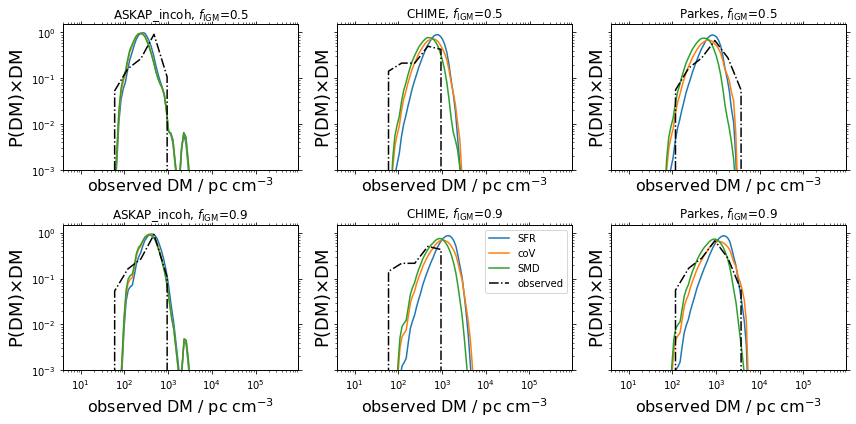

In [5]:
fig, axss = plt.subplots( 2, 3, figsize=(12,6), sharex=True, sharey=True)
for C, axs in zip( Cs[np.array([0,-1])], axss ):
    tmp = scenario.copy()
    tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]
    print(tmp)
    for telescope, ax in zip( telescopes, axs):
        ax.set_ylim(1e-3,1.5)
        #ax.set_ylim(1e-5,1.5)
        for population in populations:
            LikelihoodObservedDM( scenario=tmp, telescope=telescope, population=population, plot=True, ax=ax, plot_FRBs=population == populations[-1], label=population, title=r"%s, $f_{\rm IGM}$=%.1f" % (telescope, C) )
        AllSidesTicks(ax)
axss[1][1].legend()
fig.tight_layout()

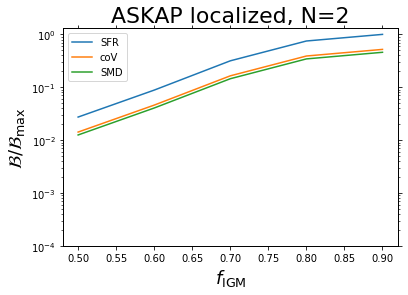

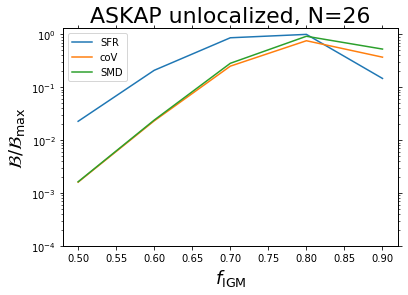

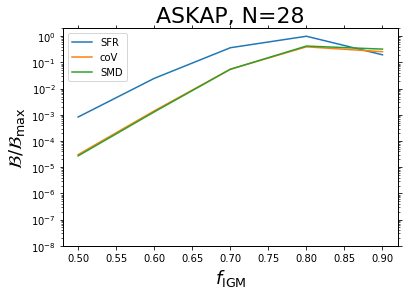

In [4]:

FRBs = GetFRBcat( telescopes=telescopes[:1])
localized = FRBs['host_redshift']>0

fig, ax = plt.subplots()
bayes_loc = BayesBaryonContentPopulationTelescope(  FRBs=FRBs[localized],  scenario=scenario, plot=True, telescope=telescopes[0], ax=ax ) 
ax.set_title( 'ASKAP localized, N=%i' % np.sum(localized) , fontdict={'size':22})
ax.set_ylim(1e-4,1.3)
AllSidesTicks(ax)
plt.show()

#'''
fig, ax = plt.subplots()
bayes_unloc = BayesBaryonContentPopulationTelescope(  FRBs=FRBs[ np.logical_not(localized)],  scenario=scenario, plot=True, telescope=telescopes[0], ax=ax ) 
ax.set_title( 'ASKAP unlocalized, N=%i' % np.sum(np.logical_not(localized)) , fontdict={'size':22})
ax.set_ylim(1e-4,1.3)
AllSidesTicks(ax)
plt.show()


fig, ax = plt.subplots()
PlotBayes2D( bayes=bayes_loc*bayes_unloc, N_bayes=len(GetFRBcat(telescopes)), x=Cs, xlabel=r"$f_{\rm IGM}$", y=populations, graphs=True, ax=ax )
ax.set_title( 'ASKAP, N=%i' % len(FRBs) , fontdict={'size':22})
ax.set_ylim(1e-8,2)
AllSidesTicks(ax)
plt.show()
#'''


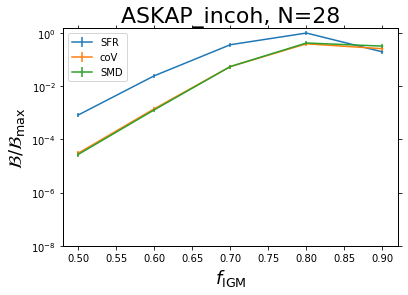

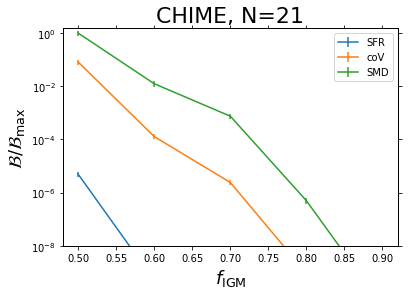

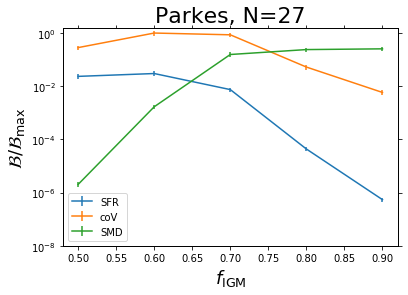

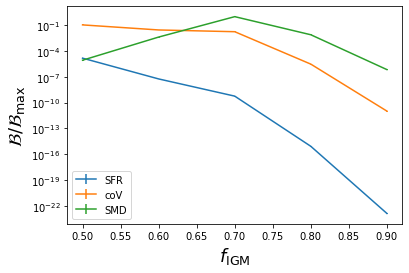

In [6]:
bayes = BayesBaryonContentPopulation(  scenario=scenario, plot=True, plot_telescopes=True )#, telescopes=['ASKAP'] ) 

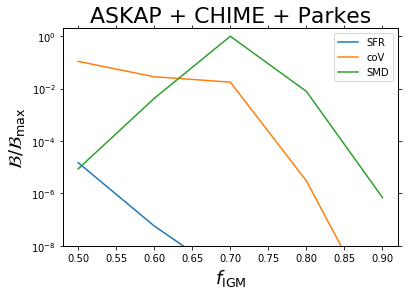

In [8]:
fig, ax = plt.subplots()

PlotBayes2D( bayes=bayes, x=Cs, xlabel=r"$f_{\rm IGM}$", y=populations, graphs=True, ax=ax)
ax.set_title( 'ASKAP + CHIME + Parkes', fontdict={'size':22})
ax.set_ylim(1e-8,2)
AllSidesTicks(ax)

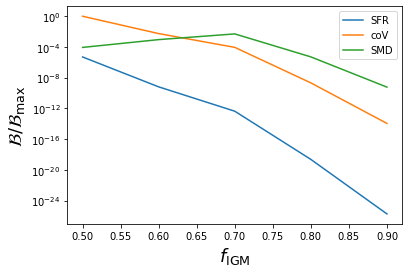

In [9]:
bayes = BayesBaryonContentPopulation(  telescopes=['CHIME','Parkes'], scenario=scenario, plot=True ) 

(1e-08, 2)

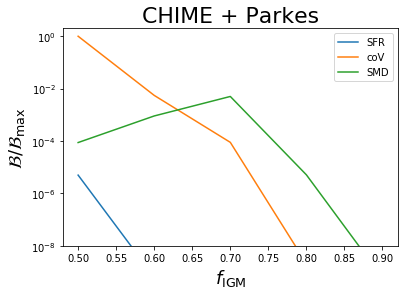

In [10]:
PlotBayes2D( bayes=bayes, x=Cs, xlabel=r"$f_{\rm IGM}$", y=populations, graphs=True)
plt.title( 'CHIME + Parkes', fontdict={'size':22})
plt.ylim(1e-8,2)

In order to arrive at the posterior likelihood of scenarios, according to Bayes Theorem, we have to factor in the prior likelihood of scenarios, than quantifies ur believes based on previous observations and theoretical arguments.
We consider all populations to be of same likelihood, while simulations suggest a value of $f_{\rm IGM} = 0.8 - 0.9$. We thus quantify the prior of $f_{\rm IGM}$ with a gaussian, whose 1$\sigma$ interval covers these values.

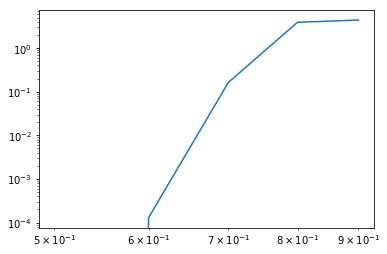

In [7]:
mu = 0.85
sigma = 0.05
N=10**6

f_IGMs_ =  np.random.normal( mu, sigma, N )
P_fIGM, fIGM = Histogram( data=f_IGMs_, bins=len(f_IGMs), range=f_IGMs_range[np.array([0,-1])], density=True )
PlotLikelihood( P=P_fIGM, x=f_IGMs_range)


def PosteriorBaryonContentPopulation( scenario={}, telescopes=telescopes, plot=False, prior=P_fIGM ):
    bayes = BayesBaryonContentPopulation(  scenario=scenario, plot=plot, telescopes=telescopes ) 
    return bayes * prior.reshape([1,len(prior)])


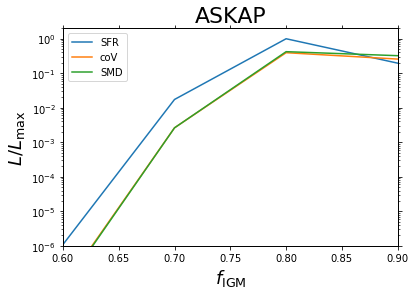

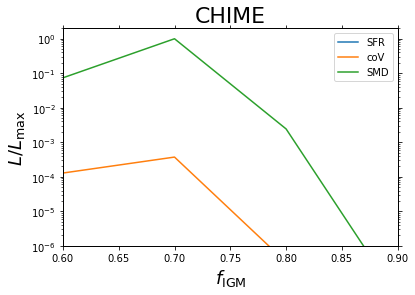

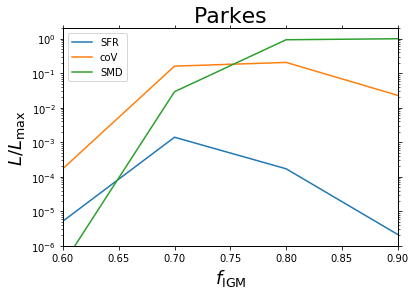

In [8]:
for telescope in telescopes:

    bayes = BayesBaryonContentPopulation(  scenario=scenario, plot_telescopes=False, telescopes=[telescope] ) 
    posterior = bayes * P_fIGM.reshape([1,len(P_fIGM)])    
    
    fig, ax = plt.subplots()
    PlotBayes2D( bayes=posterior, x=f_IGMs, xlabel=r"$f_{\rm IGM}$", y=populations, graphs=True, ax=ax, posterior=True)
    ax.set_title( labels[telescope], fontdict={'size':22})
    ax.set_ylim(1e-6,2)
    ax.set_xlim(0.6,0.9)
    AllSidesTicks(ax)


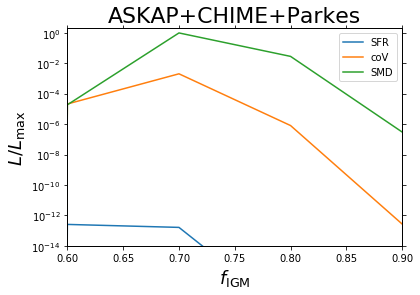

In [12]:
bayes = BayesBaryonContentPopulation(  scenario=scenario, plot_telescopes=False, telescopes=telescopes ) 
posterior = bayes * P_fIGM.reshape([1,len(P_fIGM)])

fig, ax = plt.subplots()
PlotBayes2D( bayes=posterior, x=f_IGMs, xlabel=r"$f_{\rm IGM}$", y=populations, graphs=True, ax=ax, posterior=True)
ax.set_title( "ASKAP+CHIME+Parkes", fontdict={'size':22})
ax.set_ylim(1e-14,2)
ax.set_xlim(0.6,0.9)
AllSidesTicks(ax)

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


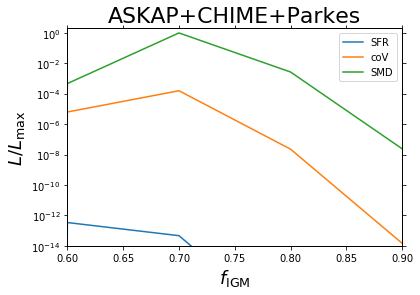

In [21]:
## here, only compute posterior form FRBs observed without RM, to be multiplied to results of IGMF inference

FRBs = GetFRBcat( telescopes=telescopes )
FRBs = FRBs[~(np.abs(FRBs['RM'])>0)]

bayes = BayesBaryonContentPopulation(  scenario=scenario, plot_telescopes=False, telescopes=telescopes, FRBs=FRBs ) 
posterior = bayes * P_fIGM.reshape([1,len(P_fIGM)])

posterior.tofile( "posterior_fIGM.npy", sep=' ')
## read with
## posterior = np.genfromtxt("posterior_fIGM.npy").reshape(len(populations),len(f_IGMs))


fig, ax = plt.subplots()
PlotBayes2D( bayes=posterior, x=f_IGMs, xlabel=r"$f_{\rm IGM}$", y=populations, graphs=True, ax=ax, posterior=True)
ax.set_title( "ASKAP+CHIME+Parkes", fontdict={'size':22})
ax.set_ylim(1e-14,2)
ax.set_xlim(0.6,0.9)
AllSidesTicks(ax)

[[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


How many FRBs are needed in order to put reasonable constraints on FRB population?
Assuming that current observations are typical for the underlying FRB population, we increase the number of FRBs and compare likelihoods for populations SMD and coV.

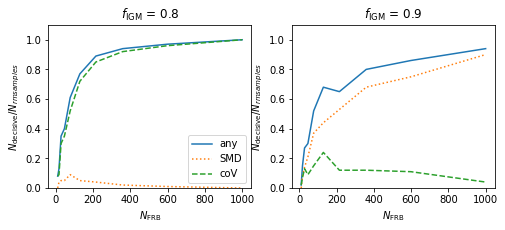

In [90]:
Ns = np.arange(40,101,10).astype('i')
Ns = np.round(10**np.linspace(1,3.,10)).astype('i')
N_std =  100

#fig, axs = plt.subplots(1, 3, figsize=(12,3))

fig, axs = plt.subplots(1, 2, figsize=(8,3))

telescope = 'Parkes'
for telescope in telescopes[-1:]:

    FRBs = GetFRBcat( telescopes=[telescope] )
    DMs = FRBs['DM'] - FRBs['DM_gal']

    P, x = Histogram( data=DMs, bins=10, log=True, density=True, range=(1e1,1e4) )
    #PlotLikelihood( P=P, x=x, measure='DM', label="observed", linestyle='-.', color='black' )

    
    
    bayes_f8, f8_std = [], []
    bayes_f9, f9_std = [], []
    decisive = []
    decisive_SMD, decisive_coV = [], []
    for N in Ns:
#    Ns_ = np.append([len(DMs)]*2, Ns)
#    for N in np.diff(Ns_):
#        DMs = np.append( DMs, RandomSample( N, P=P, x=x ) )
    #    P, x = Histogram( data=DMs, bins=10, log=True, density=True, range=(1e1,3e3) )
    #    PlotLikelihood( P=P, x=x, measure='DM', label="observed", linestyle='-.', color='black', ax=ax )
        b = []
        for i in range(N_std):
            b_ = [np.nan,np.nan]
            while np.any(np.isnan(b_)):
                DMs = RandomSample( N, P=P, x=x )
                if telescope == telescopes[0] and False:
                    P_, x_ = Histogram( data=DMs, bins=10, log=True, density=True, range=(1e1,1e4) )
                    PlotLikelihood( P=P_, x=x_, measure='DM', label="observed", linestyle='-.', color='black', ax=axs[2] )
                    PlotTelescope( measure='DM', scenario=scenario, ax=axs[2], telescope=telescope, population='SMD' )
                L_SMD = LikelihoodBaryonContent( Cs=f_IGMs[-2:], scenario=scenario, telescope=telescope, population='SMD', DMs=DMs,  )
                L_coV = LikelihoodBaryonContent( Cs=f_IGMs[-2:], scenario=scenario, telescope=telescope, population='coV', DMs=DMs,  )
                b_ = np.prod( L_SMD/L_coV, axis=1 )
            b.append( b_ )
        b = np.log10(b)
        decisive.append( np.sum( np.abs(b) >= 2, axis=0 ).astype('f') / len(b) )
        decisive_SMD.append( np.sum( b >= 2, axis=0 ).astype('f') / len(b) )
        decisive_coV.append( np.sum( b <= -2, axis=0 ).astype('f') / len(b) )
        est = np.mean(b, axis=0)
        std = np.std(b, axis=0)
        bayes_f8.append(10.**est[0])
        bayes_f9.append(10.**est[1])
        f8_std.append([10.**est[0] - 10.**(est[0]-std[0]),10.**(est[0]+std[0])-10.**est[0]])
        f9_std.append([10.**est[1] - 10.**(est[1]-std[1]),10.**(est[1]+std[1])-10.**est[1]])
#    '''
    decisive = np.array( decisive )
    decisive_SMD = np.array( decisive_SMD )
    decisive_coV = np.array( decisive_coV )
    axs[0].plot( Ns, decisive[:,0], label="any"  )
    axs[0].plot( Ns, decisive_SMD[:,0], label="SMD", linestyle=':'  )
    axs[0].plot( Ns, decisive_coV[:,0], label="coV", linestyle='--'  )
    axs[1].plot( Ns, decisive[:,1], label="any"  )
    axs[1].plot( Ns, decisive_SMD[:,1], label="SMD", linestyle=':'  )
    axs[1].plot( Ns, decisive_coV[:,1], label="coV", linestyle='--'  )
axs[0].set_ylabel(r"$N_{\rm decisive} / N_{rm samples}$")
axs[1].set_ylabel(r"$N_{\rm decisive} / N_{rm samples}$")
axs[0].set_ylim(0,1.1)
axs[1].set_ylim(0,1.1)

'''     
    axs[0].errorbar(  Ns, bayes_f8, yerr=np.array(f8_std).transpose(), label=labels[telescope]  )
    axs[1].errorbar(  Ns, bayes_f9, yerr=np.array(f9_std).transpose(), label=labels[telescope]  )
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].set_ylabel(r"$\mathcal{B}$")
axs[1].set_ylabel(r"$\mathcal{B}$")
PlotLimit( ax=axs[0], x=Ns[np.array([0,-1])], y=[1e2,1e2], label='decisive', lower_limit=True, shift_text_vertical=1000)
PlotLimit( ax=axs[0], x=Ns[np.array([0,-1])], y=[1e-2,1e-2], label='decisive', lower_limit=False, shift_text_vertical=-9e-3)
PlotLimit( ax=axs[1], x=Ns[np.array([0,-1])], y=[1e2,1e2], label='decisive', lower_limit=True, shift_text_vertical=1000)
PlotLimit( ax=axs[1], x=Ns[np.array([0,-1])], y=[1e-2,1e-2], label='decisive', lower_limit=False, shift_text_vertical=-9e-3)
#'''
axs[0].legend()
axs[0].set_title(r"$f_{\rm IGM}$ = 0.8")
axs[1].set_title(r"$f_{\rm IGM}$ = 0.9")
axs[0].set_xlabel(r"$N_{\rm FRB}$")
axs[1].set_xlabel(r"$N_{\rm FRB}$")

plt.show()

In [ ]:
    
    ## for each fIGM, infer the likelihood from each DM
    Ls = []
    for f_iGM in f_IGMs:
        Ls.append( LikelihoodObservedDM( scenario=tmp, telescope=telescope, population=population, plot=True, ax=axs[0], plot_FRBs=population == populations[-1], label=population, title=r"%s, $f_{\rm IGM}$=%.1f" % (telescope, C) ) )
    ## renormalize all events to same scenario and resulting likelihood function to 1
    Ls = np.array( Ls )
    print("Ls",Ls)
    print(np.diff(Ls, axis=1))
    print("Ls1",Ls[:1])
    print("Lsr",Ls/Ls[:1])
    
    
    bayes = np.prod( Ls / Ls[:1], axis=1 )
    print(bayes)
    bayes /= np.sum(bayes) # * np.diff(f_IGMs_range))
    print(bayes)
    axs[1].plot( f_IGMs, bayes)
#    PlotLikelihood( cumulative=0, P=bayes, x=f_IGMs_range, label="observed", linestyle='-.', color='black', ax=axs[1], density=False )

    ## from the result, obtain the estimated value
    est, dev = Likelihood2Expectation( P=bayes, x=f_IGMs_range, log=False, density=False )
    ests.append( est )
    devs.append( dev )